In [1]:
# cadCAD
from cadCAD.configuration.utils import config_sim
from cadCAD.configuration import Experiment
from cadCAD import configs
from cadCAD.engine import ExecutionMode, ExecutionContext, Executor

import random
import matplotlib.pyplot as plt 
%matplotlib inline
import pandas as pd
from collections import Counter

import sys
print(sys.getrecursionlimit())
# sys.setrecursionlimit(10000)

3000


In [2]:
# Element-wise "subtraction" for t2 from t1
def diff_between_lists(t1,t2):
    diff = []
    t1_counter = Counter(t1)
    t2_counter = Counter(t2)
    for key,value in t1_counter.items():
        if key in t2_counter:
            diff += (value - t2_counter[key])*[key]
        else:
            diff += value*[key]
    return diff

# Test
t1 = [1,1,2,3,4,4,3]
t2 = [1,3,6]
assert [1,2,3,4,4] == diff_between_lists(t1,t2), "The element-wise list-subtraction function is surely incorrect"

In [3]:
# Plot the distribution of prices used
def plot_prices(df, title):
    fig, ax1 = plt.subplots(figsize=(14,7))
    plt.plot(df)
    plt.yscale("symlog")
    plt.ylabel("IDAEP_GERMANY_VALUE_OP_[EUR/MWH]", fontsize = 14)
    plt.xlabel("Date", fontsize = 14)
    ax1.tick_params(axis='y', labelsize = 14)
    ax1.tick_params(axis='x', labelsize = 14, rotation = 45)
    plt.title(title, fontsize = 14)
    plt.grid()
    plt.show()

,IDAEP_GERMANY_VALUE_OP_[EUR/MWH]
2020-10-17 00:00:00,35.09
2020-10-17 00:15:00,33.56
2020-10-17 00:30:00,35.08
2020-10-17 00:45:00,40.54
2020-10-17 01:00:00,48.15


Number of prices: 1444


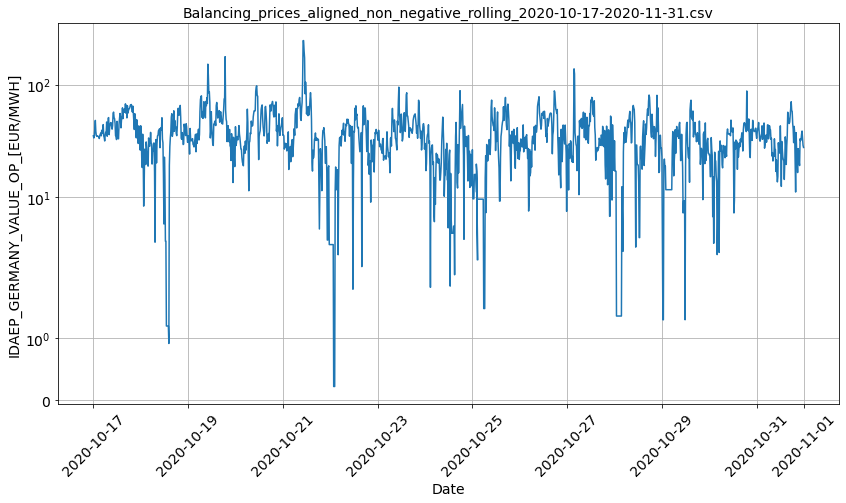

In [4]:
# Init parameters
init_tokens_in_pool = 100000
init_ethereum_in_pool = 100000

init_ethereum_trader_1 = 100
init_prices_of_tokens_trader_1 = []
init_tokens_trader_1 = len(init_prices_of_tokens_trader_1)

init_prices_of_tokens_trader_2 = [34.12, 15.78, 78.34, 34.32] 
init_ethereum_trader_2 = 200
init_tokens_trader_2 = len(init_prices_of_tokens_trader_2)

init_prices_of_tokens_trader_3 = [35.24, 12.45, 23.35] 
init_ethereum_trader_3 = 200
init_tokens_trader_3 = len(init_prices_of_tokens_trader_3)

price_file = "Balancing_prices_aligned_non_negative_rolling_2020-10-17-2020-11-31.csv"
prices_df = pd.read_csv("../Datasets/oracle-data/" + price_file, index_col = 0, parse_dates = [0])
display(prices_df.head())
prices_lst = list(prices_df["IDAEP_GERMANY_VALUE_OP_[EUR/MWH]"].values)
print("Number of prices:", len(prices_lst))
plot_prices(prices_df, price_file)


# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# List of all the state variables in the system and their initial values
genesis_states = {
    'tokens_pool': init_tokens_in_pool,
    'ethereum_pool': init_ethereum_in_pool,
    'trader_1': {
        'name': "Reckless trader",
        'tokens': init_tokens_trader_1,
        'ethereum': init_ethereum_trader_1,
        'prices_of_tokens': init_prices_of_tokens_trader_1
    },
    'trader_2': {
        'name': "Trader 2",
        'tokens': init_tokens_trader_2,
        'ethereum': init_ethereum_trader_2,
        'prices_of_tokens': init_prices_of_tokens_trader_2
    },
    'trader_3': {
        'name': "Random trader",
        'tokens': init_tokens_trader_3,
        'ethereum': init_ethereum_trader_3,
        'prices_of_tokens': init_prices_of_tokens_trader_3
    }
}

In [5]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# Settings of general simulation parameters, unrelated to the system itself
# `T` is a range with the number of discrete units of time the simulation will run for;
# `N` is the number of times the simulation will be run (Monte Carlo runs)
# `M` is the parameter dictionary  

mc = 1
num_timesteps = len(prices_lst)-1 #1000 #520 #481
sim_config_dict = {
    'T': range(num_timesteps),
    'N': 1,
    'M': {
        'fraction_of_budget_for_trading': [
            {'trader_1': 1.0, 'trader_2': 0.12, 'trader_3': 0.5}  
        ],
        'probability_of_action': [
            {'trader_1': 0.8, 'trader_2': 0.5, 'trader_3': 0.5}
        ],
        'random_trader_buy_proba': [
            {'trader_3': 0.8}
        ],
        'random_trader_sell_proba': [
            {'trader_3': 0.3}
        ],
        'random_trader_amount_of_tokens': [
            {'trader_3': 3}
        ],
        'max_tokens_to_buy': [2000],
    }
}

In [6]:
# # # # # # # # # #
# Policy functions

def no_action_return(trader):
    return {trader: {"tokens_bought": 0,
                     "tokens_sold": 0,
                     "ethereum_gained": 0,
                     "ethereum_spent": 0,
                     "tokens_sold_orig_prices": [],
                     "tokens_bought_at_prices": []}}


#generate global price per timestep
def get_price(s):
    try:
        return prices_lst[s['timestep']]
    except:
        raise Exception("Price history is not long enough")

#to generate a random price
def get_random_price(s):
    # should be based on the prices at 
    random.seed(s['timestep'])
    mean = 35
    smearing = 10
    price = mean + smearing * random.random()
    # release the seed
    random.seed(None)
    return price

# random trading
def trading_random(params, step, sH, s, trader):
    # check whether the trader will act:
    probability_of_action = params['probability_of_action'][trader]
    if random.random() > probability_of_action:
        return no_action_return(trader)
    
    # get the GLOBAL price
#     price = get_random_price(s)
    price = get_price(s)
        
    # randomly sell random tokens
    tokens_sold_orig_prices = []
    ethereum_gained = 0
    number_of_tokens = len(s[trader]['prices_of_tokens'])
    tokens_available_to_sell = s[trader]['prices_of_tokens']
    if random.random() > params['random_trader_sell_proba'][trader]:
        if number_of_tokens > 0:
            for i in range(min(number_of_tokens, params['random_trader_amount_of_tokens'][trader])):
                ind = random.choice(range(number_of_tokens-i))
                ethereum_gained += price
                tokens_sold_orig_prices.append(tokens_available_to_sell[ind])
                tokens_available_to_sell.pop(ind)
        
    # randomly buy a tokens
    tokens_bought_at_prices = []
    ethereum_trader = s[trader]["ethereum"]
    budget_for_buying = params['fraction_of_budget_for_trading'][trader]*ethereum_trader
    budget_for_buying_orig = budget_for_buying
    if random.random() > params['random_trader_buy_proba'][trader]:
        def buy_tokens(budget_for_buying, price, tokens_bought_at_prices):
            if budget_for_buying > price and\
               len(tokens_bought_at_prices) < params['random_trader_amount_of_tokens'][trader]:
                budget_for_buying -= price
                tokens_bought_at_prices.append(price)
                return buy_tokens(budget_for_buying, price, tokens_bought_at_prices)
            return budget_for_buying, tokens_bought_at_prices
        budget_for_buying, tokens_bought_at_prices = buy_tokens(budget_for_buying, price, tokens_bought_at_prices)
        
    return {trader: {"tokens_bought": len(tokens_bought_at_prices),
                     "tokens_sold": len(tokens_sold_orig_prices),
                     "ethereum_gained": ethereum_gained,
                     "ethereum_spent": budget_for_buying_orig - budget_for_buying,
                     "tokens_sold_orig_prices": tokens_sold_orig_prices,
                     "tokens_bought_at_prices": tokens_bought_at_prices}}    
    

# one generic trading policy, allows for customization via trader attributes
def trading_based_on_inventory(params, step, sH, s, trader):
    # check whether the trader will act:
    probability_of_action = params['probability_of_action'][trader]
    if random.random() > probability_of_action:
        return no_action_return(trader)
    
    # get the GLOBAL price
#     price = get_random_price(s) # the seed is fixed to the step, so this is the same for all traders and changes with step
    price = get_price(s)
#     print("price:", price)
    
    # selling tokens
    # get the prices that the tokens were purchased on
    tokens_sold_orig_prices = [i for i in s[trader]['prices_of_tokens'] if i < price]
    ethereum_gained = sum([price for i in tokens_sold_orig_prices])
    
    # buying tokens
    tokens_bought_at_prices = []
    ethereum_trader = s[trader]["ethereum"]
    budget_for_buying = params['fraction_of_budget_for_trading'][trader]*ethereum_trader
    budget_for_buying_orig = budget_for_buying
    # trader buys if she only has more expensive tokens
    if len([i for i in s[trader]['prices_of_tokens'] if i < price]) == 0:
        def buy_tokens(budget_for_buying, price, tokens_bought_at_prices):
            if budget_for_buying > price and\
               len(tokens_bought_at_prices) < params['max_tokens_to_buy']:
                budget_for_buying -= price
                tokens_bought_at_prices.append(price)
                return buy_tokens(budget_for_buying, price, tokens_bought_at_prices)
            return budget_for_buying, tokens_bought_at_prices
        budget_for_buying, tokens_bought_at_prices = buy_tokens(budget_for_buying, price, tokens_bought_at_prices)
    
    return {trader: {"tokens_bought": len(tokens_bought_at_prices),
                     "tokens_sold": len(tokens_sold_orig_prices),
                     "ethereum_gained": ethereum_gained,
                     "ethereum_spent": budget_for_buying_orig - budget_for_buying,
                     "tokens_sold_orig_prices": tokens_sold_orig_prices,
                     "tokens_bought_at_prices": tokens_bought_at_prices}}


# Define the actual traders based on the generic types:
def trader_1(params, step, sH, s):
    return trading_based_on_inventory(params, step, sH, s, 'trader_1')

def trader_2(params, step, sH, s):
    return trading_based_on_inventory(params, step, sH, s, 'trader_2')

def trader_3(params, step, sH, s):
    return trading_random(params, step, sH, s, 'trader_3')

In [7]:
# # # # # # # # # # # # # # #
# State update functions

def update_global_token(params, step, sH, s, _input):
    y = 'tokens_pool'
    x = s[y]
    for key,value in _input.items():
        x += (_input[key]['tokens_sold'] - _input[key]['tokens_bought'])  
    return (y, x)

# DO NOTHING FOR NOW
def update_global_ethereum(params, step, sH, s, _input):
    y = 'ethereum_pool'
    x = s[y]
    return (y, x)

def update_trader_inventory(params, step, sH, s, _input, trader):
    y = trader
    tokens_updated = s[y]['tokens'] + _input[y]['tokens_bought'] - _input[y]['tokens_sold']
    ethereum_updated = s[y]['ethereum'] + _input[y]['ethereum_gained'] - _input[y]['ethereum_spent']
    prices_of_tokens_updated = diff_between_lists(s[y]['prices_of_tokens'], _input[y]['tokens_sold_orig_prices'])+\
                               _input[y]['tokens_bought_at_prices']
    x = {'name': s[y]['name'],
         'tokens': tokens_updated,
         'ethereum': ethereum_updated,
         'prices_of_tokens': prices_of_tokens_updated}
    return (y, x)

def update_trader_1_inventory(params, step, sH, s, _input):
    return update_trader_inventory(params, step, sH, s, _input, "trader_1")

def update_trader_2_inventory(params, step, sH, s, _input):
    return update_trader_inventory(params, step, sH, s, _input, "trader_2")

def update_trader_3_inventory(params, step, sH, s, _input):
    return update_trader_inventory(params, step, sH, s, _input, "trader_3")

In [8]:
# # # # # # # # # # # # # # # # # # # #
# Partial State Update Block

partial_state_update_blocks = [
    { 
        'policies': {
            'trader_1': trader_1,
            'trader_2': trader_2,
            'trader_3': trader_3
        },
        'variables': {
            'tokens_pool': update_global_token,
            'ethereum_pool': update_global_ethereum,
            'trader_1': update_trader_1_inventory,
            'trader_2': update_trader_2_inventory,
            'trader_3': update_trader_3_inventory
        }
    }
]

In [9]:
# Run
del configs[:]

exp = Experiment()
c = config_sim(sim_config_dict)
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# The configurations above are then packaged into a `Configuration` object
exp.append_configs(initial_state=genesis_states, #dict containing variable names and initial values
                       partial_state_update_blocks=partial_state_update_blocks, #dict containing state update functions
                       sim_configs=c #preprocessed dictionaries containing simulation parameters
                      )

# exec_mode = ExecutionMode()
# multi_mode_ctx = ExecutionContext(context=exec_mode.multi_proc)
# run = Executor(exec_context=multi_mode_ctx, configs=configs)

exec_mode = ExecutionMode()
local_mode_ctx = ExecutionContext(exec_mode.local_mode)
executor = Executor(local_mode_ctx, configs) # Pass the configuration object inside an array
raw_result, tensor, sessions = executor.execute() # The `execute()` method returns a tuple; its first elements contains the 

# raw_result, tensor_field, sessions = run.execute()
result_df = pd.DataFrame(raw_result)


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

Execution Mode: local_proc
Configuration Count: 1
Dimensions of the first simulation: (Timesteps, Params, Runs, Vars) = (1443, 6, 1, 5)
Execution Method: local_simulations
SimIDs   : [0]
SubsetIDs: [0]
Ns       : [0]
ExpIDs   : [0]
Execution Mode: single_threaded
Total execution time: 4.74s


In [10]:
display(result_df.head(10))

,tokens_pool,ethereum_pool,trader_1,trader_2,trader_3,simulation,subset,run,substep,timestep
0,100000,100000,"{'name': 'Reckless trader', 'tokens': 0, 'ethe...","{'name': 'Trader 2', 'tokens': 4, 'ethereum': ...","{'name': 'Random trader', 'tokens': 3, 'ethere...",0,0,1,0,0
1,100006,100000,"{'name': 'Reckless trader', 'tokens': 0, 'ethe...","{'name': 'Trader 2', 'tokens': 1, 'ethereum': ...","{'name': 'Random trader', 'tokens': 0, 'ethere...",0,0,1,1,1
2,100004,100000,"{'name': 'Reckless trader', 'tokens': 2, 'ethe...","{'name': 'Trader 2', 'tokens': 1, 'ethereum': ...","{'name': 'Random trader', 'tokens': 0, 'ethere...",0,0,1,1,2
3,100004,100000,"{'name': 'Reckless trader', 'tokens': 2, 'ethe...","{'name': 'Trader 2', 'tokens': 1, 'ethereum': ...","{'name': 'Random trader', 'tokens': 0, 'ethere...",0,0,1,1,3
4,100006,100000,"{'name': 'Reckless trader', 'tokens': 0, 'ethe...","{'name': 'Trader 2', 'tokens': 1, 'ethereum': ...","{'name': 'Random trader', 'tokens': 0, 'ethere...",0,0,1,1,4
5,100004,100000,"{'name': 'Reckless trader', 'tokens': 2, 'ethe...","{'name': 'Trader 2', 'tokens': 1, 'ethereum': ...","{'name': 'Random trader', 'tokens': 0, 'ethere...",0,0,1,1,5
6,100004,100000,"{'name': 'Reckless trader', 'tokens': 2, 'ethe...","{'name': 'Trader 2', 'tokens': 1, 'ethereum': ...","{'name': 'Random trader', 'tokens': 0, 'ethere...",0,0,1,1,6
7,100003,100000,"{'name': 'Reckless trader', 'tokens': 2, 'ethe...","{'name': 'Trader 2', 'tokens': 2, 'ethereum': ...","{'name': 'Random trader', 'tokens': 0, 'ethere...",0,0,1,1,7
8,100003,100000,"{'name': 'Reckless trader', 'tokens': 2, 'ethe...","{'name': 'Trader 2', 'tokens': 2, 'ethereum': ...","{'name': 'Random trader', 'tokens': 0, 'ethere...",0,0,1,1,8
9,100003,100000,"{'name': 'Reckless trader', 'tokens': 2, 'ethe...","{'name': 'Trader 2', 'tokens': 2, 'ethereum': ...","{'name': 'Random trader', 'tokens': 0, 'ethere...",0,0,1,1,9


In [11]:
def plot_trader_inventory(trader, result_df = result_df):
    fig, ax1 = plt.subplots(figsize=(14,7))
    color = 'tab:red'
    ax1.set_xlabel('Timestep', fontsize=14)
    ax1.set_ylabel('Ethereum', color=color, fontsize=14)
    ax1.plot(result_df["timestep"], result_df[trader].apply(lambda x: x["ethereum"]), color=color)
    ax1.tick_params(axis='y', labelcolor=color, labelsize = 14)
    ax1.tick_params(axis='x', labelsize = 14)
#     ax2.xticks=list(result_df['timestep'].drop_duplicates())
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:blue'
    ax2.set_ylabel('Tokens', color=color, fontsize = 14)
    ax2.plot(result_df["timestep"], result_df[trader].apply(lambda x: x["tokens"]), color=color)
    ax2.tick_params(axis='y', labelcolor=color, labelsize = 14)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    ax1.grid(axis='both')
    plt.title(result_df[trader].apply(lambda x: x["name"])[0], fontsize=16)
    plt.show()

def plot_global_pool(result_df = result_df):
    fig, ax1 = plt.subplots(figsize=(14,7))
    color = 'tab:red'
    ax1.set_xlabel('Timestep', fontsize=14)
    ax1.set_ylabel('Ethereum', color=color, fontsize=14)
    ax1.plot(result_df["timestep"], result_df["ethereum_pool"], color=color)
    ax1.tick_params(axis='y', labelcolor=color, labelsize = 14)
    ax1.tick_params(axis='x', labelsize = 14)
#     ax2.xticks=list(result_df['timestep'].drop_duplicates())
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:blue'
    ax2.set_ylabel('Tokens', color=color, fontsize = 14)
    ax2.plot(result_df["timestep"], result_df["tokens_pool"], color=color)
    ax2.tick_params(axis='y', labelcolor=color, labelsize = 14)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    ax1.grid(axis='both')
    plt.title("Global pool", fontsize=16)
    plt.show()

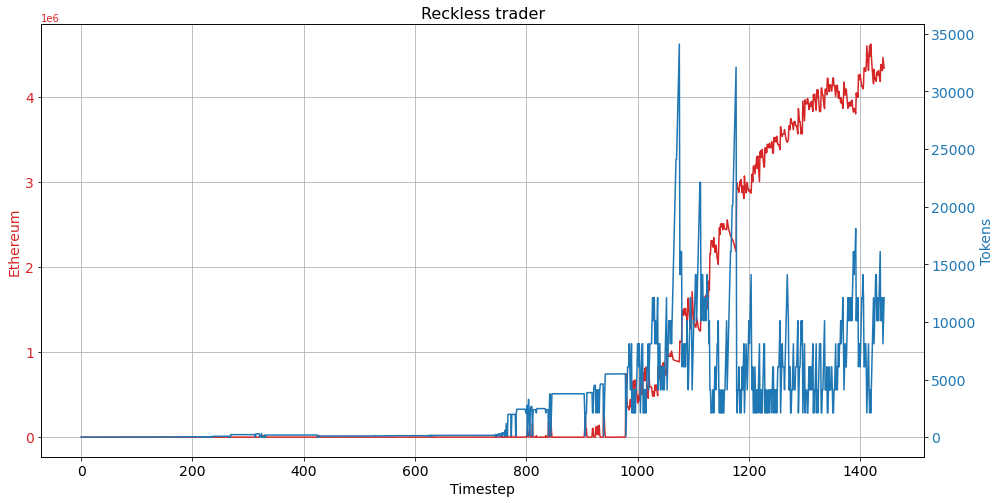

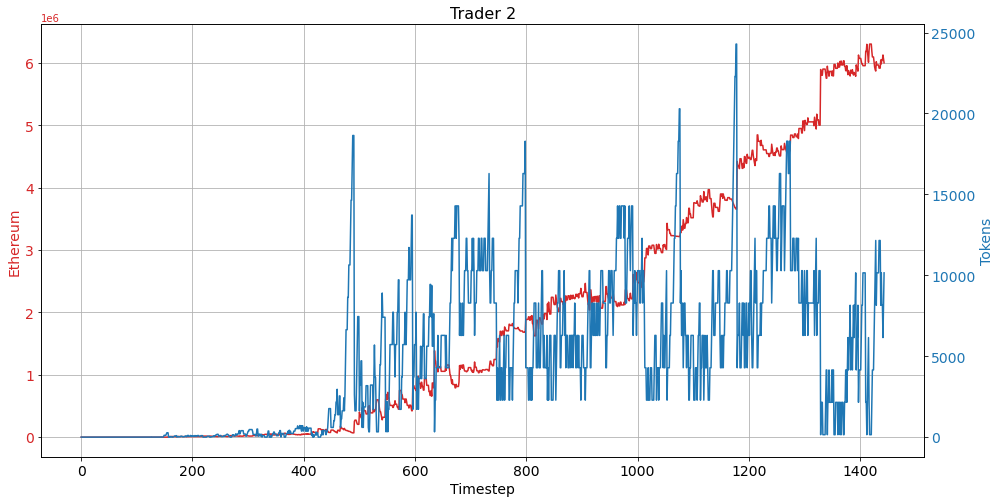

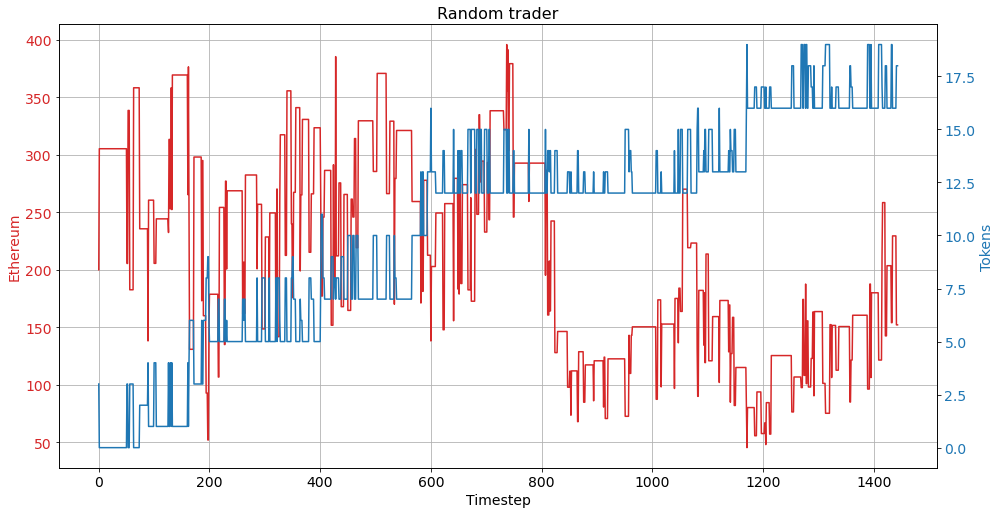

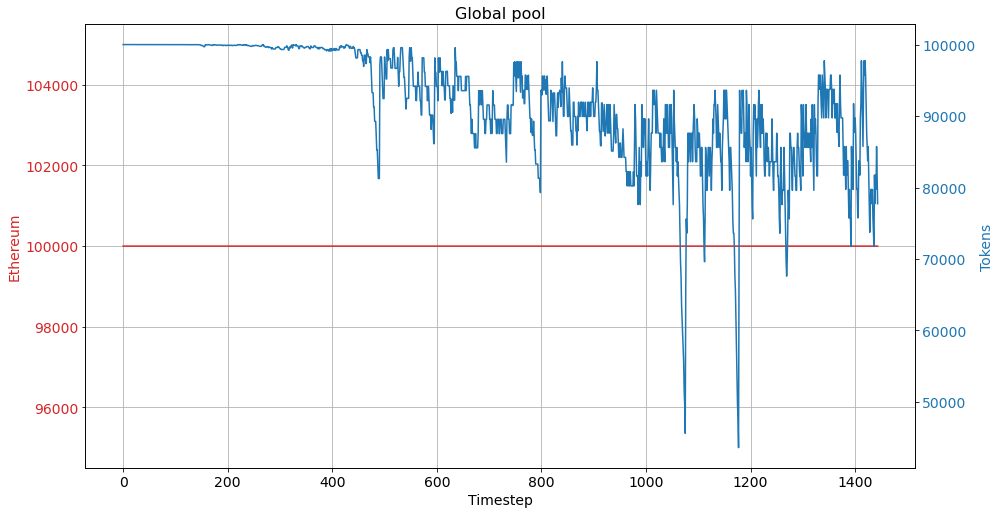

In [12]:
plot_trader_inventory("trader_1")
plot_trader_inventory("trader_2")
plot_trader_inventory("trader_3")
plot_global_pool()

In [13]:
display(result_df.head())
display(result_df.tail())


,tokens_pool,ethereum_pool,trader_1,trader_2,trader_3,simulation,subset,run,substep,timestep
0,100000,100000,"{'name': 'Reckless trader', 'tokens': 0, 'ethe...","{'name': 'Trader 2', 'tokens': 4, 'ethereum': ...","{'name': 'Random trader', 'tokens': 3, 'ethere...",0,0,1,0,0
1,100006,100000,"{'name': 'Reckless trader', 'tokens': 0, 'ethe...","{'name': 'Trader 2', 'tokens': 1, 'ethereum': ...","{'name': 'Random trader', 'tokens': 0, 'ethere...",0,0,1,1,1
2,100004,100000,"{'name': 'Reckless trader', 'tokens': 2, 'ethe...","{'name': 'Trader 2', 'tokens': 1, 'ethereum': ...","{'name': 'Random trader', 'tokens': 0, 'ethere...",0,0,1,1,2
3,100004,100000,"{'name': 'Reckless trader', 'tokens': 2, 'ethe...","{'name': 'Trader 2', 'tokens': 1, 'ethereum': ...","{'name': 'Random trader', 'tokens': 0, 'ethere...",0,0,1,1,3
4,100006,100000,"{'name': 'Reckless trader', 'tokens': 0, 'ethe...","{'name': 'Trader 2', 'tokens': 1, 'ethereum': ...","{'name': 'Random trader', 'tokens': 0, 'ethere...",0,0,1,1,4


,tokens_pool,ethereum_pool,trader_1,trader_2,trader_3,simulation,subset,run,substep,timestep
1439,81742,100000,"{'name': 'Reckless trader', 'tokens': 10098, '...","{'name': 'Trader 2', 'tokens': 8151, 'ethereum...","{'name': 'Random trader', 'tokens': 16, 'ether...",0,0,1,1,1439
1440,79742,100000,"{'name': 'Reckless trader', 'tokens': 12098, '...","{'name': 'Trader 2', 'tokens': 8151, 'ethereum...","{'name': 'Random trader', 'tokens': 16, 'ether...",0,0,1,1,1440
1441,85740,100000,"{'name': 'Reckless trader', 'tokens': 8098, 'e...","{'name': 'Trader 2', 'tokens': 6151, 'ethereum...","{'name': 'Random trader', 'tokens': 18, 'ether...",0,0,1,1,1441
1442,81740,100000,"{'name': 'Reckless trader', 'tokens': 10098, '...","{'name': 'Trader 2', 'tokens': 8151, 'ethereum...","{'name': 'Random trader', 'tokens': 18, 'ether...",0,0,1,1,1442
1443,77740,100000,"{'name': 'Reckless trader', 'tokens': 12098, '...","{'name': 'Trader 2', 'tokens': 10151, 'ethereu...","{'name': 'Random trader', 'tokens': 18, 'ether...",0,0,1,1,1443


In [22]:
result_df["Tokens - Random trader"] = result_df["trader_3"].apply(lambda x: x["tokens"])
result_df["Tokens in t-1 - Random trader"] = result_df["Tokens - Random trader"].shift(1)
result_df.loc[0,"Tokens in t-1 - Random trader"] = genesis_states["trader_3"]["tokens"]

result_df["Tokens - Reckless trader"] = result_df["trader_1"].apply(lambda x: x["tokens"])
result_df["Tokens in t-1 - Reckless trader"] = result_df["Tokens - Reckless trader"].shift(1)
result_df.loc[0,"Tokens in t-1 - Reckless trader"] = genesis_states["trader_1"]["tokens"]

result_df["Delta Tokens - Random trader"] = result_df["Tokens in t-1 - Random trader"] - result_df["Tokens - Random trader"]
result_df["Delta Tokens - Reckless trader"] = result_df["Tokens in t-1 - Reckless trader"] - result_df["Tokens - Reckless trader"]

display(result_df.head())
display(result_df[["Delta Tokens - Random trader", "Delta Tokens - Reckless trader"]])

,tokens_pool,ethereum_pool,trader_1,trader_2,trader_3,simulation,subset,run,substep,timestep,Tokens - Random trader,Tokens in t-1 - Random trader,Tokens - Reckless trader,Tokens in t-1 - Reckless trader,Delta Tokens - Random trader,Delta Tokens - Reckless trader
0,100000,100000,"{'name': 'Reckless trader', 'tokens': 0, 'ethe...","{'name': 'Trader 2', 'tokens': 4, 'ethereum': ...","{'name': 'Random trader', 'tokens': 3, 'ethere...",0,0,1,0,0,3,3.0,0,0.0,0.0,0.0
1,100006,100000,"{'name': 'Reckless trader', 'tokens': 0, 'ethe...","{'name': 'Trader 2', 'tokens': 1, 'ethereum': ...","{'name': 'Random trader', 'tokens': 0, 'ethere...",0,0,1,1,1,0,3.0,0,0.0,3.0,0.0
2,100004,100000,"{'name': 'Reckless trader', 'tokens': 2, 'ethe...","{'name': 'Trader 2', 'tokens': 1, 'ethereum': ...","{'name': 'Random trader', 'tokens': 0, 'ethere...",0,0,1,1,2,0,0.0,2,0.0,0.0,-2.0
3,100004,100000,"{'name': 'Reckless trader', 'tokens': 2, 'ethe...","{'name': 'Trader 2', 'tokens': 1, 'ethereum': ...","{'name': 'Random trader', 'tokens': 0, 'ethere...",0,0,1,1,3,0,0.0,2,2.0,0.0,0.0
4,100006,100000,"{'name': 'Reckless trader', 'tokens': 0, 'ethe...","{'name': 'Trader 2', 'tokens': 1, 'ethereum': ...","{'name': 'Random trader', 'tokens': 0, 'ethere...",0,0,1,1,4,0,0.0,0,2.0,0.0,2.0


,Delta Tokens - Random trader,Delta Tokens - Reckless trader
0,0.0,0.0
1,3.0,0.0
2,0.0,-2.0
3,0.0,0.0
4,0.0,2.0
...,...,...
1439,0.0,2000.0
1440,0.0,-2000.0
1441,-2.0,4000.0
1442,0.0,-2000.0


In [21]:
# Write out the df
result_df[["Delta Tokens - Random trader", "Delta Tokens - Reckless trader"]].to_pickle(
    "../Datasets/cadcad-simulation-data/cadcad_traders_setup_1.pkl")